# Analysis

> This notebook will contain an analysis of the sentiments

In glassdoor_sentiment_analysis.ipynb, I ran a sentiment analysis on the data that I scraped from Glassdoor. In this notebook, I will analyze the sentiment and ratings towards a company over time, the accuracy of each method (using the rating to justify), and word frequency. Looking at the rating over time will allow me to determine if there were any peaks or valleys which could lead to further analysis as to why the peaks and valleys occured (ex. work from home order). Also, each method grades the text differently. Thus, I will use the rating to determine which sentiment method is most accurate for the text responses and I will also look at if there is a category of text response that is better at predicting the rating. Lastly, I will look at word frequencies which should give evidence to similarities among positive, negative, and neutral reviews.

## Table of Contents

    1. Data Overview
    
        a. Current vs Former Employeess
        
        b. Proportion of Industries Represented
        
    2. Sentiment Analysis
        
    3. Text Analysis
    
        a. Word Frequency (time trend to show how often work life balance appeared before COVID)
            
            I. Pros
            
            II. Cons
            
        b. Look at Ratings for reviews containing words in each
    
    4. Work From Home (WFH) Analysis
        
        a. isolate WFH words (our dictionary)
        
        b. time trend to see if there are any spikes
        
        c. correlation with rating
        
        d. correlates with turnover

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import statistics

# sentiment and word processing
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.probability import FreqDist

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# tf-idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\19012\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19012\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\19012\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\19012\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\19012\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
data = pd.read_csv('sentiment_analysis.csv')

## Data Overview

In [3]:
print(data.shape)
data.head()

(668597, 51)


,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis
0,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexiblitiy is great amongest staff,the work load is overwhelming at times,NaN,2022-03-15,Customer Relations,NaN,NaN,NaN,1.0,flexiblitiy is great amongest staff the work l...,2022,3.0,"[('flexiblitiy', 'n'), ('great', 'a'), ('among...","[('work', 'n'), ('load', 'n'), ('overwhelming'...","[('nan', 'n')]","[('flexiblitiy', 'n'), ('great', 'a'), ('among...",flexiblitiy great amongest staff,work load overwhelming times,NaN,flexiblitiy great amongest staff work load ove...,flexiblitiy great amongest staff,work load overwhelm time,nan,flexiblitiy great amongest staff work load...,0.8,Positive,0.000000,Neutral,0.000000,Neutral,0.800000,Positive,0.6249,-0.1779,0.0000,0.5267,Positive,Neutral,Neutral,Positive
1,AMERICAN AIRLINES GROUP INC,3.0,4.0,3.0,5.0,3.0,3.0,3.0,yes,no,neutral,Flexible schedules great flight benefits great...,Constantly understaffed in all areas Poor mana...,Hire more people so we aren t constantly delay...,2022-03-15,American Airlines Flight Attendant,New York,NY,5.0,1.0,Flexible schedules great flight benefits great...,2022,3.0,"[('Flexible', 'a'), ('schedules', 'n'), ('grea...","[('Constantly', 'r'), ('understaffed', 'v'), (...","[('Hire', 'n'), ('people', 'n'), ('constantly'...","[('Flexible', 'a'), ('schedules', 'n'), ('grea...",Flexible schedules great flight benefits great...,Constantly understaffed areas Poor management ...,Hire people constantly delayed cancelled,Flexible schedules great flight benefits great...,Flexible schedule great flight benefit great...,Constantly understaffed area Poor management...,Hire people constantly delay cancel,Flexible schedule great flight benefit great...,0.8,Positive,-0.266667,Negative,0.000000,Neutral,0.133333,Positive,0.9201,-0.8176,-0.5106,0.3182,Positive,Negative,Negative,Neutral
2,AMERICAN AIRLINES GROUP INC,5.0,5.0,5.0,5.0,5.0,5.0,5.0,yes,yes,yes,Love my job Love the freedom not being microma...,Reserve reserve reserve not being able to hold...,NaN,2022-03-15,Flight Attendant,NaN,NaN,NaN,1.0,Love my job Love the freedom not being microma...,2022,3.0,"[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...","[('Reserve', 'n'), ('reserve', 'v'), ('reserve...","[('nan', 'n')]","[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...",Love job Love freedom micromanage,Reserve reserve reserve able hold fll,NaN,Love job Love freedom micromanage Reserve rese...,Love job Love freedom micromanage,Reserve reserve reserve able hold fll,nan,Love job Love freedom micromanage Reserve ...,0.5,Positive,0.500000,Positive,0.000000,Neutral,0.500000,Positive,0.9274,0.0000,0.0000,0.9274,Positive,Neutral,Neutral,Positive
3,AMERICAN AIRLINES GROUP INC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quit after one month with the company,Working conditions customer service Terrance,Stop being a company full of uneducated low li...,2022-03-15,Pilot,NaN,NaN,NaN,0.0,Quit after one month with the company Working...,2022,3.0,"[('Quit', 'n'), ('one', None), ('month', 'n'),...","[('Working', 'v'), ('conditions', 'n'), ('cust...","[('Stop', 'n'), ('company', 'n'), ('full', 'a'...","[('Quit', 'n'), ('one', None), ('month', 

In [5]:
data.columns[data.columns.str.contains('sub')]

Index(['sub_work_life_balance', 'sub_culture_values',
       'sub_diversity_inclusion', 'sub_career_opportunities',
       'sub_compensation_benefits', 'sub_senior_management'],
      dtype='object')

In [6]:
# missing observations as percentage
for i in data.columns[data.columns.str.contains('sub')]:
    print('missing observations in {}: {}'.format(i,round(data['sub_work_life_balance'].isna().sum()/data.shape[0],2)))

missing observations in sub_work_life_balance: 0.21
missing observations in sub_culture_values: 0.21
missing observations in sub_diversity_inclusion: 0.21
missing observations in sub_career_opportunities: 0.21
missing observations in sub_compensation_benefits: 0.21
missing observations in sub_senior_management: 0.21


In [7]:
# remove *_pos_tagged, *_Lemma, *_Analysis

In [8]:
data.company.nunique()

100

In [7]:
# only keep years 2018-2022
years = ['2022', '2021', '2020', '2019', '2018', 2022, 2021, 2020, 2019, 2018]
data = data[data.year.isin(years)]

### Current vs Former Employees

For this analysis, we can potentially determine if work from home has affected turnover rates. For example, Employee A moves to Company Y from Company X because Company X did not offer a flexible work location. Thus, I will look at the proportion of current employees to former employees over the date range collected to see how it is correlated to the turnover rate for companies at that time period.

In [10]:
# proportion of current employees
data.current_employee.sum()/data.shape[0]

0.5852896231583197

In [11]:
data.year.unique()

array(['2022', '2021', '2020', '2019', '2018', 2019, 2018, 2022, 2021,
       2020], dtype=object)

In [8]:
# plot the time series for this ratio
data_years = data[data.year.isin(years)]
print(data_years.shape)

# take the average for each year
data_year_group = pd.DataFrame(data_years.groupby('year').mean()['current_employee']).reset_index()
data_year_group['year'] = data_year_group['year'].astype('int')
data_year_group = data_year_group.groupby('year').mean().reset_index()
data_year_group

(636891, 51)


,year,current_employee
0,2018,0.572779
1,2019,0.609761
2,2020,0.582760
3,2021,0.623376
4,2022,0.669348


In [9]:
# take the average for each company
data_comp_group = pd.DataFrame(data_years.groupby(['year', 'company']).mean()['current_employee']).reset_index()

# make sure we only have one year value
data_comp_group['year'] = data_comp_group['year'].astype('int')
data_comp_group = data_comp_group.groupby(['year', 'company']).mean().reset_index().sort_values(['company', 'year'])

# data_comp_group.to_csv('C:/Users/19012/Documents/sp22-capstone/company_turnover.csv', index=False)
data_comp_group.head()

,year,company,current_employee
0,2018,3M CO,0.622419
271,2019,3M CO,0.642651
551,2020,3M CO,0.597260
837,2021,3M CO,0.683252
1127,2022,3M CO,0.715686


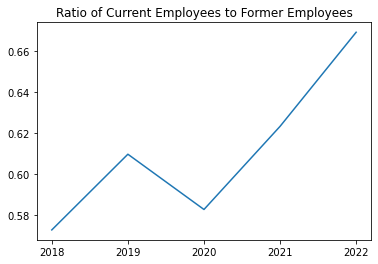

In [10]:
plt.plot(data_year_group['year'], data_year_group['current_employee']);
plt.title('Ratio of Current Employees to Former Employees');
plt.locator_params(nbins=8)

### Proportion of industries represented

As of 3/28/22, I have 100 companies that have been scraped. However, after completing the scrape, I realized that there was not a reason why I chose the companies that I did. I read in the SP500 data and used the first 100 companies in that list. Now, I must find the distribution of industries represented in the scraped data and ensure that it matches the distribution of companies in the SP500.

In [11]:
# proportion of industries to actual dataset
sp500 = pd.read_excel('Glassdoor SP500 sample.xlsx')
print(sp500.shape)
sp500.head()

(723, 11)


,obs,gvkey,permno,ticker,comnam,ncusip,shrcd,exchcd,hsiccd,glassdoor_url_reviews,glassdoor_url_company
0,1,1045,21020.0,AAL,AMERICAN AIRLINES GROUP INC,02376R10,11.0,3.0,4512.0,https://www.glassdoor.com/Reviews/American-Air...,https://www.glassdoor.com/Overview/Working-at-...
1,2,1075,27991.0,PNW,PINNACLE WEST CAPITAL CORP,72348410,11.0,1.0,4911.0,https://www.glassdoor.com/Reviews/Pinnacle-Wes...,https://www.glassdoor.com/Overview/Working-at-...
2,3,1078,20482.0,ABT,ABBOTT LABORATORIES,282410,11.0,1.0,5047.0,https://www.glassdoor.com/Reviews/Abbott-Revie...,https://www.glassdoor.com/Overview/Working-at-...
3,4,1161,61241.0,AMD,ADVANCED MICRO DEVICES INC,790310,11.0,1.0,3674.0,https://www.glassdoor.com/Reviews/AMD-Reviews-...,https://www.glassdoor.com/Overview/Working-at-...
4,5,1177,88845.0,AET,AETNA INC NEW,00817Y10,11.0,1.0,6324.0,https://www.glassdoor.com/Reviews/Aetna-Review...,https://www.glassdoor.com/Overview/Working-at-...


In [16]:
print(int(sp500.hsiccd.min()))
print(sp500.hsiccd.max())

721
9999.0


In [17]:
sp500[sp500.hsiccd<1000]

,obs,gvkey,permno,ticker,comnam,ncusip,shrcd,exchcd,hsiccd,glassdoor_url_reviews,glassdoor_url_company
319,320,11456,39917.0,WY,WEYERHAEUSER CO,96216610,18.0,1.0,831.0,NaN,NaN
531,532,35168,18592.0,CTVA,CORTEVA INC,22052L10,11.0,1.0,721.0,NaN,NaN


There are only 2 agriculture companies in the sp500 dataset and neither of these 2 companies are scraped.

In [18]:
print('WEYERHAEUSER CO' in list(data.company))
'CORTEVA INC' in list(data.company)

False


False

In [12]:
new_df = data.merge(sp500, left_on=['company'], right_on=['comnam'])

In [20]:
new_df.shape

(160717, 62)

In [13]:
# split hsiccd
new_df['hsiccd'] = new_df.hsiccd.astype('int').astype('str')
hsiccd_1 = []
hsiccd_2 = []
for i in new_df['hsiccd']:
    if len(i) == 3:
        # implied 0 at beginning for the 3 didgit codes
        hsiccd_1.append(0)
    else:
        hsiccd_1.append(i[0])
        hsiccd_2.append(i[:2])
    
new_df['hsiccd_1'] = hsiccd_1
new_df['hsiccd_2'] = hsiccd_2

new_df.head()

,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,obs,gvkey,permno,ticker,comnam,ncusip,shrcd,exchcd,hsiccd,glassdoor_url_reviews,glassdoor_url_company,hsiccd_1,hsiccd_2
0,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexiblitiy is great amongest staff,the work load is overwhelming at times,NaN,2022-03-15,Customer Relations,NaN,NaN,NaN,1.0,flexiblitiy is great amongest staff the work l...,2022,3.0,"[('flexiblitiy', 'n'), ('great', 'a'), ('among...","[('work', 'n'), ('load', 'n'), ('overwhelming'...","[('nan', 'n')]","[('flexiblitiy', 'n'), ('great', 'a'), ('among...",flexiblitiy great amongest staff,work load overwhelming times,NaN,flexiblitiy great amongest staff work load ove...,flexiblitiy great amongest staff,work load overwhelm time,nan,flexiblitiy great amongest staff work load...,0.8,Positive,0.000000,Neutral,0.000000,Neutral,0.800000,Positive,0.6249,-0.1779,0.0000,0.5267,Positive,Neutral,Neutral,Positive,1,1045,21020.0,AAL,AMERICAN AIRLINES GROUP INC,02376R10,11.0,3.0,4512,https://www.glassdoor.com/Reviews/American-Air...,https://www.glassdoor.com/Overview/Working-at-...,4,45
1,AMERICAN AIRLINES GROUP INC,3.0,4.0,3.0,5.0,3.0,3.0,3.0,yes,no,neutral,Flexible schedules great flight benefits great...,Constantly understaffed in all areas Poor mana...,Hire more people so we aren t constantly delay...,2022-03-15,American Airlines Flight Attendant,New York,NY,5.0,1.0,Flexible schedules great flight benefits great...,2022,3.0,"[('Flexible', 'a'), ('schedules', 'n'), ('grea...","[('Constantly', 'r'), ('understaffed', 'v'), (...","[('Hire', 'n'), ('people', 'n'), ('constantly'...","[('Flexible', 'a'), ('schedules', 'n'), ('grea...",Flexible schedules great flight benefits great...,Constantly understaffed areas Poor management ...,Hire people constantly delayed cancelled,Flexible schedules great flight benefits great...,Flexible schedule great flight benefit great...,Constantly understaffed area Poor management...,Hire people constantly delay cancel,Flexible schedule great flight benefit great...,0.8,Positive,-0.266667,Negative,0.000000,Neutral,0.133333,Positive,0.9201,-0.8176,-0.5106,0.3182,Positive,Negative,Negative,Neutral,1,1045,21020.0,AAL,AMERICAN AIRLINES GROUP INC,02376R10,11.0,3.0,4512,https://www.glassdoor.com/Reviews/American-Air...,https://www.glassdoor.com/Overview/Working-at-...,4,45
2,AMERICAN AIRLINES GROUP INC,5.0,5.0,5.0,5.0,5.0,5.0,5.0,yes,yes,yes,Love my job Love the freedom not being microma...,Reserve reserve reserve not being able to hold...,NaN,2022-03-15,Flight Attendant,NaN,NaN,NaN,1.0,Love my job Love the freedom not being microma...,2022,3.0,"[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...","[('Reserve', 'n'), ('reserve', 'v'), ('reserve...","[('nan', 'n')]","[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...",Love job Love freedom micromanage,Reserve reserve reserve able hold fll,NaN,Love job Love freedom micromanage Reserve rese...,Love job Love freedom micromanage,Reserve reserve reserve able hold fll,nan,Love job Love freedom micromanage Reserve ...,0.5,Positive,0.500000,Positive,0.000000,Neutral,0.500000,Positive,0.9274,0.0000,0.0000,0.9274,Positive,Neutral,Neutral,Positive,1,1045,21020.0,AAL,AME

In [14]:
# split hsiccd
sp500['hsiccd'] = sp500.hsiccd.astype('str')
sp500['hsiccd'] = sp500['hsiccd'].str.split('.', 1, expand=True)[0]
hsiccd_1 = []
hsiccd_2 = []
for i in sp500['hsiccd']:
    hsiccd_1.append(i[0])
    hsiccd_2.append(i[:2])
    
sp500['hsiccd_1'] = hsiccd_1
sp500['hsiccd_2'] = hsiccd_2

sp500.head()

,obs,gvkey,permno,ticker,comnam,ncusip,shrcd,exchcd,hsiccd,glassdoor_url_reviews,glassdoor_url_company,hsiccd_1,hsiccd_2
0,1,1045,21020.0,AAL,AMERICAN AIRLINES GROUP INC,02376R10,11.0,3.0,4512,https://www.glassdoor.com/Reviews/American-Air...,https://www.glassdoor.com/Overview/Working-at-...,4,45
1,2,1075,27991.0,PNW,PINNACLE WEST CAPITAL CORP,72348410,11.0,1.0,4911,https://www.glassdoor.com/Reviews/Pinnacle-Wes...,https://www.glassdoor.com/Overview/Working-at-...,4,49
2,3,1078,20482.0,ABT,ABBOTT LABORATORIES,282410,11.0,1.0,5047,https://www.glassdoor.com/Reviews/Abbott-Revie...,https://www.glassdoor.com/Overview/Working-at-...,5,50
3,4,1161,61241.0,AMD,ADVANCED MICRO DEVICES INC,790310,11.0,1.0,3674,https://www.glassdoor.com/Reviews/AMD-Reviews-...,https://www.glassdoor.com/Overview/Working-at-...,3,36
4,5,1177,88845.0,AET,AETNA INC NEW,00817Y10,11.0,1.0,6324,https://www.glassdoor.com/Reviews/Aetna-Review...,https://www.glassdoor.com/Overview/Working-at-...,6,63


In [15]:
sp500 = sp500[['comnam', 'hsiccd_1', 'hsiccd_2']]
sp500 = sp500.sort_values('hsiccd_1').reset_index().drop('index', axis=1)
sp500.head()

,comnam,hsiccd_1,hsiccd_2
0,LENNAR CORP,1,15
1,PHILLIPS 66,1,13
2,ROWAN COMPANIES INC,1,13
3,D R HORTON INC,1,15
4,CHESAPEAKE ENERGY CORP,1,13


In [24]:
sp500[sp500.hsiccd_1==0]

,comnam,hsiccd_1,hsiccd_2


In [16]:
new_df = new_df[['company', 'hsiccd_1', 'hsiccd_2']]
new_df.head()

,company,hsiccd_1,hsiccd_2
0,AMERICAN AIRLINES GROUP INC,4,45
1,AMERICAN AIRLINES GROUP INC,4,45
2,AMERICAN AIRLINES GROUP INC,4,45
3,AMERICAN AIRLINES GROUP INC,4,45
4,AMERICAN AIRLINES GROUP INC,4,45


In [17]:
# new_df = new_df.drop_duplicates().reset_index().drop('index', axis=1)
new_df = new_df.drop_duplicates().sort_values('hsiccd_1').reset_index().drop('index', axis=1)
new_df.head()

,company,hsiccd_1,hsiccd_2
0,PULTE GROUP INC,1,15
1,MURPHY OIL CORP,1,13
2,APACHE CORP,1,13
3,NABORS INDUSTRIES LTD,1,13
4,MARATHON OIL CORP,1,13


In [18]:
sp500_test = pd.DataFrame(sp500.hsiccd_1.value_counts()/(sp500.shape[0])).reset_index().sort_values('index', ascending=True)
sp500_test

,index,hsiccd_1
6,1,0.069156
2,2,0.147994
0,3,0.221300
3,4,0.130014
5,5,0.099585
1,6,0.156293
4,7,0.103734
7,8,0.034578
9,9,0.017981
8,n,0.019364


In [19]:
print(sp500[sp500.hsiccd_1 == 'n'].shape)
sp500[sp500.hsiccd_1 == 'n']

(14, 3)


,comnam,hsiccd_1,hsiccd_2
709,VERSUM MATERIALS INC,n,na
710,INGEVITY CORP,n,na
711,FOUR CORNERS PROPERTY TR INC,n,na
712,BIOVERATIV INC,n,na
713,APERGY CORP,n,na
714,JBG SMITH PPTYS,n,na
715,SUN MICROSYSTEMS INC,n,na
716,QUALITY CARE PROPERTIES INC,n,na
717,ADVANSIX INC,n,na
718,CONDUENT INC,n,na


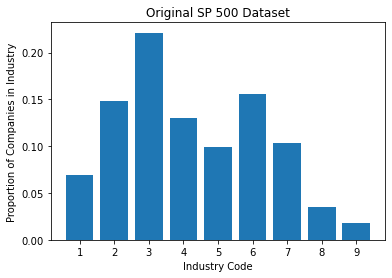

In [20]:
plt.bar(sp500_test[sp500_test['index'] != 'n']['index'], height=sp500_test[sp500_test['index'] != 'n']['hsiccd_1']);
plt.title('Original SP 500 Dataset');
plt.xlabel('Industry Code')
plt.ylabel('Proportion of Companies in Industry');

In [21]:
new_df_test = pd.DataFrame(new_df.hsiccd_1.value_counts()/(new_df.shape[0])).reset_index().sort_values('index', ascending=True)
new_df_test

,index,hsiccd_1
5,1,0.066406
2,2,0.144531
0,3,0.289062
1,4,0.167969
4,5,0.117188
3,6,0.121094
6,7,0.058594
7,8,0.027344
8,9,0.007812


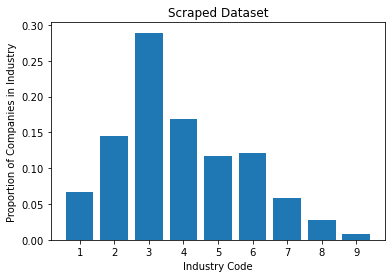

In [22]:
plt.bar(new_df_test['index'], height=new_df_test['hsiccd_1']);
plt.title('Scraped Dataset');
plt.xlabel('Industry Code')
plt.ylabel('Proportion of Companies in Industry');

-----------

In [23]:
# add in review length (number of charcters)
data['characters'] = data['free_text_response'].str.len()

# add in review length (number of words)
data['pros_words'] = data['pros'].apply(lambda x: len(str(x).split(' ')))
data['cons_words'] = data['cons'].apply(lambda x: len(str(x).split(' ')))
data['advice_words'] = data['advice_management'].apply(lambda x: len(str(x).split(' ')))
data['free_text_words'] = data['free_text_response'].apply(lambda x: len(str(x).split(' ')))

# average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_length'] = data['free_text_response'].apply(lambda x: avg_word(x))

In [24]:
print(data.pros_words.describe())

count    636891.000000
mean         11.673355
std          14.375546
min           1.000000
25%           6.000000
50%           8.000000
75%          12.000000
max         991.000000
Name: pros_words, dtype: float64


In [25]:
print(data.cons_words.describe())

count    636891.000000
mean         17.479569
std          34.874191
min           1.000000
25%           6.000000
50%           9.000000
75%          16.000000
max        3469.000000
Name: cons_words, dtype: float64


In [26]:
print(data.advice_words.describe())

count    636891.000000
mean          5.907383
std          16.666553
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1158.000000
Name: advice_words, dtype: float64


In [27]:
# 'recommend', 'ceo_approval', 'outlook'
# data.recommend.describe()
# data['recommend'] = data.recommend.replace(['yes', 'no'], [1,2])
data.outlook.describe()

count     404960
unique         3
top          yes
freq      234469
Name: outlook, dtype: object

In [37]:
# one hot encode recommend, ceo_approval, outlook

## Sentiment Analysis

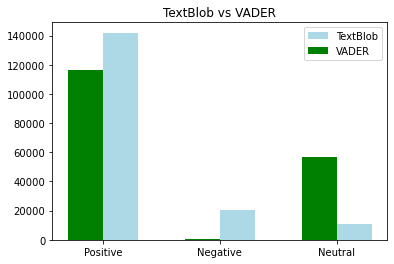

In [38]:
tb_counts = data.free_text_Analysis.value_counts()
vader_counts = data.pros_vader_analysis.value_counts()

textBlob = pd.DataFrame(tb_counts).reset_index().rename(columns={'index': 'polarity'})
vader = pd.DataFrame(vader_counts).reset_index().rename(columns={'index': 'polarity'})
blob_vader = textBlob.merge(vader, on='polarity')

fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(blob_vader.polarity, height=blob_vader.free_text_Analysis, align='edge', width=0.3, color='lightblue', label='TextBlob')
plt.bar(blob_vader.polarity, height=blob_vader.pros_vader_analysis, align='edge', width=-0.3, color='green', label='VADER')
plt.xticks(np.arange(3), ('Positive', 'Negative', 'Neutral'))
plt.legend();
plt.title('TextBlob vs VADER');

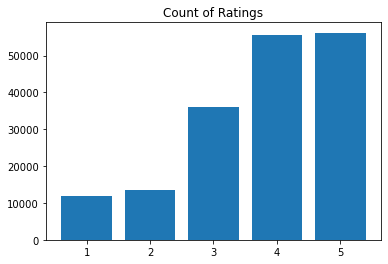

In [39]:
ratings = pd.DataFrame(data.rating.value_counts()).reset_index().rename(columns={'rating': 'number', 'index': 'rating'})
fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(ratings.rating, height=ratings.number);
plt.title('Count of Ratings');

In [28]:
print('average rating:', np.mean(data['rating']))
print('average TextBlob polarity:', np.mean(data['free_text_Polarity']))
print('average Vader sentiment:', np.mean(data['free_text_vader_sentiment']))
print('most common rating:', statistics.mode(data['rating']))
print('Frequency of each rating:')
print(data['rating'].value_counts())

average rating: 3.672146411238344
average TextBlob polarity: 0.2597999368496861
average Vader sentiment: 0.5554753136724645
most common rating: 4.0
Frequency of each rating:
4.0    197872
5.0    192062
3.0    142110
2.0     55782
1.0     49065
Name: rating, dtype: int64


Looking at averages, both TextBlob and Vader seem to offer a pretty good indication of rating. The average rating of 3.23 shows that ratings are just above neutral and the TextBlob score is 0.19 which is just above 0 which was the neutral score for TextBlob. Vader's netural score ranged from \[-0.5\, 0.5\] and its score is 0.37 which is on the upper end of neutral. Thus, I do not think that it matters which score is used for this analysis as both are accurate. However, personally, I feel like TextBlob is more intuitive because a positive score reflects a positive sentiment and negative score reflects a negative sentiment.

In [41]:
# see if there's any correlation between the overall rating and the subratings
ratings = ['rating', 'sub_work_life_balance', 'sub_culture_values', 'sub_diversity_inclusion', 'sub_career_opportunities', 'sub_compensation_benefits', 'sub_senior_management']
data[ratings].corr()[['rating']]

,rating
rating,1.000000
sub_work_life_balance,0.625166
sub_culture_values,0.780547
sub_diversity_inclusion,0.683133
sub_career_opportunities,0.663372
sub_compensation_benefits,0.683741
sub_senior_management,0.757217


In [42]:
# other correlations
# rating to each polarity score (pros, cons, advice, free text)
select_cols = ['rating', 'pros_Polarity', 'cons_Polarity', 'advice_Polarity', 'free_text_Polarity', 'sub_work_life_balance', 'sub_culture_values', 'sub_diversity_inclusion', 'sub_career_opportunities', 'sub_compensation_benefits', 'sub_senior_management']
data[select_cols].corr()[['rating', 'sub_work_life_balance', 'sub_culture_values', 'sub_diversity_inclusion', 'sub_career_opportunities', 'sub_compensation_benefits', 'sub_senior_management']].iloc[:5]

,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management
rating,1.000000,0.625166,0.780547,0.683133,0.663372,0.683741,0.757217
pros_Polarity,0.187484,0.147020,0.177272,0.143106,0.160046,0.159970,0.164686
cons_Polarity,0.120207,0.110253,0.113854,0.102855,0.107689,0.100655,0.127841
advice_Polarity,-0.005303,0.014711,0.007278,0.006854,0.015905,0.008343,0.006808
free_text_Polarity,0.285765,0.230118,0.273636,0.233650,0.243142,0.252851,0.267297


While none of the polarity scores are strongly correlated with the outcome, the score with the highest correlation is the free text (all text columns combined). 

In [43]:
# other correlations
# rating to each polarity score (pros, cons, advice, free text)
select_cols = ['rating', 'pros_vader_sentiment', 'cons_vader_sentiment', 'advice_management_vader_sentiment', 'free_text_vader_sentiment', 'sub_work_life_balance', 'sub_culture_values', 'sub_diversity_inclusion', 'sub_career_opportunities', 'sub_compensation_benefits', 'sub_senior_management']
data[select_cols].corr()[['rating', 'sub_work_life_balance', 'sub_culture_values', 'sub_diversity_inclusion', 'sub_career_opportunities', 'sub_compensation_benefits', 'sub_senior_management']].iloc[:5]

,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management
rating,1.000000,0.625166,0.780547,0.683133,0.663372,0.683741,0.757217
pros_vader_sentiment,0.243429,0.193630,0.260137,0.217760,0.246104,0.226226,0.224303
cons_vader_sentiment,0.041281,0.068404,0.048737,0.020336,0.010184,0.023134,0.045981
advice_management_vader_sentiment,-0.082066,-0.044707,-0.065763,-0.061772,-0.050847,-0.068697,-0.071506
free_text_vader_sentiment,0.226438,0.193732,0.240458,0.189983,0.201773,0.195997,0.211411


As with the polarity score, the vader sentiment only offers correlation on the low-moderate correlation end of the specturm.

Some previous research suggests that outlook is useful in predicting sales. I want to see how well outlook predicts rating.

In [44]:
data.outlook.unique()

array([nan, 'neutral', 'yes', 'no'], dtype=object)

In [45]:
data['outlook'] = data.outlook.replace(['neutral', 'no', 'yes'], [0,-1,1])
data.outlook.unique()

array([nan,  0.,  1., -1.])

In [46]:
data.corr()['outlook']

rating                               0.633571
sub_work_life_balance                0.447208
sub_culture_values                   0.596225
sub_diversity_inclusion              0.524713
sub_career_opportunities             0.488305
sub_compensation_benefits            0.527220
sub_senior_management                0.594669
outlook                              1.000000
years                               -0.047501
current_employee                     0.171730
month                               -0.004095
pros_Polarity                        0.138275
cons_Polarity                        0.105027
advice_Polarity                      0.007271
free_text_Polarity                   0.234129
pros_vader_sentiment                 0.202411
cons_vader_sentiment                 0.045887
advice_management_vader_sentiment   -0.053042
free_text_vader_sentiment            0.194390
characters                          -0.199579
pros_words                           0.026880
cons_words                        

In [47]:
from scipy import stats
# data.outlook[~data.outlook.isna()]

corr_df = data[['outlook', 'rating']]
corr_df = corr_df[~corr_df.outlook.isna()]
stats.pearsonr(corr_df.outlook, corr_df.rating)

(0.6335705813741649, 0.0)

# Text analysis

Now that we've seen the sentiment among the reviews, maybe we could do a text analysis of each sentiment. What are the common words being used for each sentiment? 

In [48]:
print(data['title'].value_counts())
print('')
print('number of unique positions:', data.title.nunique())

Anonymous Employee                          22470
Anonymous Employee                           5734
                                             2364
Software Engineer                            1656
Customer Service Representative              1649
                                            ...  
Customer Sales & Service Representative         1
Collections Associate                           1
Talent Management                               1
SWAG                                            1
Sales and Marketing Director                    1
Name: title, Length: 29887, dtype: int64

number of unique positions: 29887


I don't think that the above value counts will be beneficial to our analysis, especially if we are looking at 100+ companies. The job titles would be too broad.

In [49]:
# employee status
data.current_employee.sum()/data.shape[0]

0.5852896231583197

It's about a 50/50 split of current/former employees. I would say that this benefits the analysis we can still look at the data set as a whole and not worry about a bias coming from current or former employees because they should offset each other which would leave us with a well-rounded analysis. This means that we would also have a decent analysis if we wanted to compare current employees reviews to former employee reviews.

In [50]:
print('average number of years at company:', data[data['current_employee'] == 1].years.mean())
print('average number of years away from company:', data[data['current_employee'] == 0].years.mean())

average number of years at company: 3.7338734307437593
average number of years away from company: 3.6950111004063166


Current employees are averaging about 3 years at the company while former employees have been away from the company for about 2.5 years. I think 3 years on average is a good length of time for an employee to develop an understanding of the compnay and develop a solid opinion of the company. 2.5 years on average for former employees could lead to reviews that might be a little inaccurate. Thus, I might just stick to current employees.

count    173415.000000
mean         35.812173
std          54.296200
min           5.000000
25%          14.000000
50%          20.000000
75%          35.000000
max        4229.000000
Name: free_text_words, dtype: float64
95% of responses fall within -72.78022744448208 and 144.40457366597388free_text_words


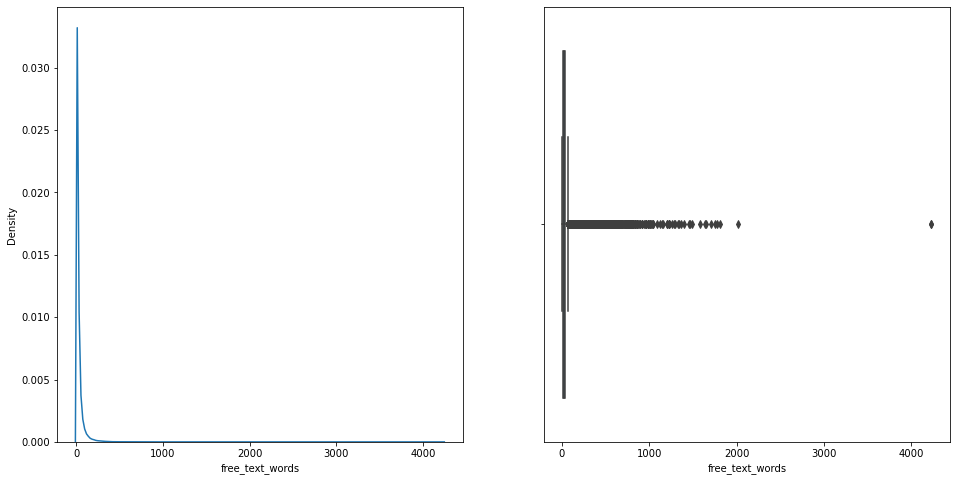

In [51]:
# descriptive stats for length of reviews
print(data['free_text_words'].describe())
print('95% of responses fall within ' + str(data['free_text_words'].mean() - data['free_text_words'].std()*2) + ' and ' + str(data['free_text_words'].mean() + data['free_text_words'].std()*2) + 'free_text_words')
# graph distribution of lentghs
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

sns.kdeplot(data['free_text_words'], ax=axs[0]);
# plt.axvline(data['free_text_response'].str.len().mean(), color='red');
# plt.axvline(data['free_text_response'].str.len().median(), color = 'green');

sns.boxplot(data['free_text_words'], ax=axs[1]);

In [52]:
data.free_text_words.median()

20.0

Typically we use the median to get the average when the data is skewed; however, we could use either in this case as they both represent the middle. I might look to exclude the outliers because the longest reviews is 9725 words, but the 75th quantile is 275 words.

Let's start by using all of the data because the lengthier reviews could provide better insight into the company.

--------------

# Rating Trends

In [53]:
# group by year
# table output should be year, sentiment, count
# data['year'] = data['date'].str.split('-', n=2, expand=True)[0].astype('int')
# data['month'] = data['date'].str.split('-', n=2, expand=True)[1].astype('int')
# print(data.shape)
# data.head()

We should make sure that the polarity score and overall rating have the same trends to ensure that the sentiments are correct.

## Compare Senitment Scores with Ratings

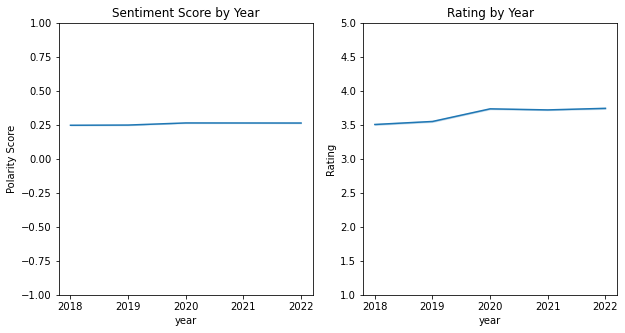

In [29]:
# compare polarity with overall rating
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sentiment_plot = sns.lineplot(x=data.year.astype('str'), y=data.free_text_Polarity, ax=axs[0])#, label='polarity')
# sns.lineplot(x=data.year.astype('str'), y=data.free_text_vader_sentiment, ax=axs[0],label='vader')
sentiment_plot.set_ylim(data.free_text_Polarity.min(),data.free_text_Polarity.max());
sentiment_plot.set(title='Sentiment Score by Year');
sentiment_plot.invert_xaxis();
sentiment_plot.set_ylabel('Polarity Score');

rating_plot = sns.lineplot(x=data.year.astype('str'), y=data.rating, ax=axs[1])
rating_plot.set_ylim(data.rating.min(),data.rating.max());
rating_plot.set(title='Rating by Year');
rating_plot.invert_xaxis();
rating_plot.set_ylabel('Rating');

## Pros Section

### TF-IDF

Calculating the term frequency is beneficial; however, some words carry a heavier weight and are more descriptive when used. For example, the word "the" is used frequently, but we cannot derive the meaning of a sentence from this word because it is used frequently and used in many sentences. Thus, we can calculate the TF-IDF to weight words that are more descriptive within a sentence.

We will break this down by section in the reviews (pros, cons, combined text). We hope to find different words in each section as this would show what makes someone think highly of a company as opposed to what makes someone think negatively of a company.

#### Term Frequency

First, calculate the term frequency of the words in the corpus. This is calculated by finding the the total number of times a word is used in the corpus and dividing that by the total number of words in the corpus.

In [40]:
pros_freq = data.pros_remove_stop.str.lower().str.split(expand=True).stack().value_counts() / data.free_text_words.sum()
pros_freq = pd.DataFrame(pros_freq, columns=['freq']).reset_index().rename(columns={'index': 'word'})

In [41]:
pros_freq.sort_values(by=['freq'], ascending=False)[:20]

,word,freq
0,good,0.010789
1,work,0.009806
2,great,0.008159
3,benefits,0.005360
4,pay,0.003897
5,company,0.003835
6,people,0.003529
7,environment,0.002543
8,life,0.002182
9,culture,0.002156


#### IDF

Also look at the TF-IDF. This will allow us to see the importance of each word being used (ie. if a word is used frequently, but is used in most reviews, then we don't gain much information about the word). The IDF is a weighting factor that tells us how important a word is.

In [42]:
# remove those values na in column
data = data[~data.pros_remove_stop.str.lower().isnull()]

In [43]:
count = CountVectorizer()
word_count_pros=count.fit_transform(data.pros_remove_stop.str.lower())
# print(word_count)

tfidf_transformer_pros=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer_pros.fit(word_count_pros)
df_idf_pros = pd.DataFrame(tfidf_transformer_pros.idf_, index=count.get_feature_names(),columns=["idf_weights"]).reset_index().rename(columns={'index': 'word'})

#inverse document frequency
df_idf_pros.sort_values(by=['idf_weights'], ascending=False)

,word,idf_weights
18444,kangaroo,13.671116
19737,longervthere,13.671116
19781,lording,13.671116
19777,lopen,13.671116
19773,looser,13.671116
...,...,...
24256,pay,3.016177
3264,benefits,2.688496
14754,great,2.415537
36361,work,2.196510


In [44]:
# join word frequency table with idf table
df_idf_pros = pros_freq.merge(df_idf_pros, how='inner', on='word')
df_idf_pros['tfidf'] = df_idf_pros.freq*df_idf_pros.idf_weights

In [45]:
df_idf_pros.sort_values(by='tfidf', ascending=False)[:10]

,word,freq,idf_weights,tfidf
0,good,0.010789,2.163323,0.023339
1,work,0.009806,2.196510,0.021538
2,great,0.008159,2.415537,0.019708
3,benefits,0.005360,2.688496,0.014409
5,company,0.003835,3.082236,0.011820
4,pay,0.003897,3.016177,0.011753
6,people,0.003529,3.133196,0.011056
7,environment,0.002543,3.430210,0.008721
8,life,0.002182,3.582041,0.007818
9,culture,0.002156,3.597021,0.007756


### Phrases

## Cons Section

### Term Frequency

In [46]:
word_freq_cons = data.cons_remove_stop.str.lower().str.split(expand=True).stack().value_counts() / data.free_text_words.sum()
word_freq_cons = pd.DataFrame(word_freq_cons, columns=['freq']).reset_index().rename(columns={'index': 'word'})

In [47]:
word_freq_cons.sort_values(by=['freq'], ascending=False)

,word,freq
0,work,6.255787e-03
1,management,4.019386e-03
2,company,2.945681e-03
3,hours,2.664557e-03
4,pay,2.494817e-03
...,...,...
38530,stabilise,4.478624e-08
38529,theworknumber,4.478624e-08
38528,yesman,4.478624e-08
38527,confessing,4.478624e-08


Also look at the TF-IDF. This will allow us to see the importance of each word being used (ie. if a word is used frequently, but is used in most reviews, then we don't gain much information about the word). The IDF is a weighting factor that tells us how important a word is.

### IDF

In [48]:
# remove those values na in column
data = data[~data.cons_remove_stop.str.lower().isnull()]

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

count = CountVectorizer()
word_count=count.fit_transform(data.cons_remove_stop)
# print(word_count)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf_cons = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"]).reset_index().rename(columns={'index':'word'})

#inverse document frequency
df_idf_cons.sort_values(by=['idf_weights'], ascending=False)

,word,idf_weights
53655,zzzz,13.670545
35726,plesanton,13.670545
17094,extenders,13.670545
17093,extender,13.670545
17092,extendended,13.670545
...,...,...
34543,pay,3.520882
22464,hours,3.456343
8877,company,3.426149
28272,management,3.090599


In [50]:
# join word frequency table with idf table
df_tfidf_cons = word_freq_cons.merge(df_idf_cons, how='inner', on='word')
df_tfidf_cons['tfidf'] = df_tfidf_cons.freq*df_tfidf_cons.idf_weights
rank_cons = df_tfidf_cons.sort_values(by='tfidf', ascending=False).reset_index().rename(columns={'index': 'cons_rank'})
rank_cons[:50]

,cons_rank,word,freq,idf_weights,tfidf
0,0,work,0.006256,2.698819,0.016883
1,1,management,0.004019,3.090599,0.012422
2,2,company,0.002946,3.426149,0.010092
3,3,hours,0.002665,3.456343,0.009210
4,4,pay,0.002495,3.520882,0.008784
5,5,time,0.002244,3.704576,0.008311
6,6,get,0.002216,3.748064,0.008307
7,8,people,0.001883,3.930960,0.007402
8,7,employees,0.001890,3.910178,0.007389
9,9,long,0.001742,3.830983,0.006675


In [51]:
rank_pros = df_idf_pros.sort_values(by='tfidf', ascending=False).reset_index().rename(columns={'index': 'pros_rank'})
rank_pros[:50]

,pros_rank,word,freq,idf_weights,tfidf
0,0,good,0.010789,2.163323,0.023339
1,1,work,0.009806,2.196510,0.021538
2,2,great,0.008159,2.415537,0.019708
3,3,benefits,0.005360,2.688496,0.014409
4,5,company,0.003835,3.082236,0.011820
5,4,pay,0.003897,3.016177,0.011753
6,6,people,0.003529,3.133196,0.011056
7,7,environment,0.002543,3.430210,0.008721
8,8,life,0.002182,3.582041,0.007818
9,9,culture,0.002156,3.597021,0.007756


In [52]:
rank = rank_cons.merge(rank_pros, how='inner', on='word')
rank.head()

,cons_rank,word,freq_x,idf_weights_x,tfidf_x,pros_rank,freq_y,idf_weights_y,tfidf_y
0,0,work,0.006256,2.698819,0.016883,1,0.009806,2.196510,0.021538
1,1,management,0.004019,3.090599,0.012422,20,0.001360,4.072931,0.005538
2,2,company,0.002946,3.426149,0.010092,5,0.003835,3.082236,0.011820
3,3,hours,0.002665,3.456343,0.009210,19,0.001440,4.017629,0.005786
4,4,pay,0.002495,3.520882,0.008784,4,0.003897,3.016177,0.011753


In [53]:
pd.DataFrame(rank.cons_rank[:50] - rank.pros_rank[:50]).reset_index().rename(columns={0: 'difference', 'index': 'value'}).merge(rank, how='inner', left_on=['value'], right_on=['cons_rank'])[['word', 'difference']].sort_values(by='difference')

,word,difference
30,lack,-1330
28,poor,-1327
19,balance,-970
33,team,-729
38,little,-332
26,sometimes,-314
36,less,-310
15,low,-282
45,great,-211
23,bad,-170


Management appears as the second most important word in the cons; however, management does not appear in the top 10 most important words for pros. Does management only stick out when people hate the company? Does management drive them away? Environment is a similar word except it appears in the pros top 10, but not the cons top 50.  

### Phrases

--------------

In [226]:
# import topics dataset as well and use the keywords to create a dictionary for wlb words

While we have not written the code for the phrases, Prof. White has ran the phrases analysis already and that is what we are using.

In [54]:
# read in files from DropBox
phrases_cons = pd.read_excel('phrases_cons.xlsx')
phrases_pros = pd.read_excel('phrases_pros.xlsx')
topics_free_text = pd.read_excel('topics_freetext_n20.xlsx')

In [10]:
phrases_cons.head()

,Unnamed: 0,FREQUENCY,NO. CASES,% CASES,LENGTH,TF • IDF
0,LIFE BALANCE,7008,6955,0.0400,2,9799.5
1,WORK LIFE BALANCE,6724,6672,0.0383,3,9523.7
2,LONG HOURS,3588,3567,0.0205,2,6057.7
3,UPPER MANAGEMENT,1814,1712,0.0098,2,3640.9
4,LOW PAY,1780,1770,0.0102,2,3546.9


In [11]:
phrases_pros.head()

,Unnamed: 0,FREQUENCY,NO. CASES,% CASES,LENGTH,TF • IDF
0,LIFE BALANCE,13013,12979,0.0746,2,14670.6
1,WORK LIFE BALANCE,12565,12534,0.0720,3,14355.9
2,GREAT BENEFITS,8312,8308,0.0477,2,10981.2
3,GOOD BENEFITS,7003,6987,0.0401,2,9778.5
4,GOOD WORK,5831,5752,0.0331,2,8634.6


In [13]:
topics_free_text.head()

,NO,TOPIC,KEYWORDS,COHERENCE,FREQ,CASES,% CASES
0,12,LIFE BALANCE,BALANCE; LIFE; WORK; \n\nLIFE BALANCE; WORK LI...,0.307,68203,35184,0.2022
1,15,GREAT BENEFITS\nMOVE,MOVE; GREAT; COMPANY; BENEFITS; HARD; \n\nGREA...,0.302,19006,17501,0.1006
2,7,UPPER MANAGEMENT,MANAGEMENT; UPPER; EMPLOYEES; PAY; POOR; \n\nU...,0.315,13922,11018,0.0633
3,9,CAREER GROWTH,CAREER; GROWTH; OPPORTUNITIES; LIMITED; ADVANC...,0.360,10588,9660,0.0555
4,8,FLEXIBLE HOURS\nSCHEDULE,FLEXIBLE; SCHEDULE; HOURS; \n\nFLEXIBLE HOURS;...,0.302,6115,5873,0.0337


Work life balance shows up in both lists, so we can show a time trend that this has mattered before COVID

In [55]:
# time trend of the phrase 'work life balance'
# filter by this phrase
wlb = data[data.free_text_remove_stop.str.lower().str.contains('work life balance')]
wlb.head()

,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,characters,pros_words,cons_words,advice_words,free_text_words,avg_length
42,AMERICAN AIRLINES GROUP INC,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flight benefits and that is all,no work life balance lack of support from mana...,NaN,2022-03-04,Project Manager,NaN,NaN,NaN,1.0,flight benefits and that is all no work life b...,2022,3.0,"[('flight', 'n'), ('benefits', 'n')]","[('work', 'n'), ('life', 'n'), ('balance', 'n'...","[('nan', 'n')]","[('flight', 'n'), ('benefits', 'n'), ('work', ...",flight benefits,work life balance lack support management obvi...,NaN,flight benefits work life balance lack support...,flight benefit,work life balance lack support management ob...,nan,flight benefit work life balance lack supp...,0.000000,Neutral,0.000000,Neutral,0.00,Neutral,0.000000,Neutral,0.4588,0.2732,0.0000,0.6249,Neutral,Neutral,Neutral,Positive,107,6,11,1,18,5.000000
91,AMERICAN AIRLINES GROUP INC,3.0,2.0,3.0,5.0,2.0,2.0,3.0,yes,no,no,Traveling the world First Class Most of Time,Too political Not enough time to work life bal...,Promote from within first Follow Southwest s p...,2022-02-24,Analyst,Raleigh,NC,5.0,0.0,Traveling the world First Class Most of Time T...,2022,2.0,"[('Traveling', 'v'), ('world', 'n'), ('First',...","[('political', 'a'), ('enough', 'a'), ('time',...","[('Promote', 'n'), ('within', None), ('first',...","[('Traveling', 'v'), ('world', 'n'), ('First',...",Traveling world First Class Time,political enough time work life balance salary...,Promote within first Follow Southwest people c...,Traveling world First Class Time political eno...,Traveling world First Class Time,political enough time work life balance sala...,Promote within first Follow Southwest people...,Traveling world First Class Time political...,0.250000,Positive,0.080952,Positive,-0.01,Negative,0.057143,Positive,0.0000,0.8271,0.2732,0.8689,Neutral,Positive,Neutral,Positive,469,8,43,20,71,5.700000
107,AMERICAN AIRLINES GROUP INC,3.0,1.0,2.0,2.0,4.0,3.0,1.0,yes,no,neutral,Home based Easy system to learn Travel benefit...,Poverty pay Strict on breaks No time off Manda...,NaN,2022-02-21,Reservations Agent,NaN,NaN,1.0,1.0,Home based Easy system to learn Travel benefit...,2022,2.0,"[('Home', 'n'), ('based', 'v'), ('Easy', 'n'),...","[('Poverty', 'n'), ('pay', 'n'), ('Strict', 'n...","[('nan', 'n')]","[('Home', 'n'), ('based', 'v'), ('Easy', 'n'),...",Home based Easy system learn Travel benefits k...,Poverty pay Strict breaks time Mandatory overt...,NaN,Home based Easy system learn Travel benefits k...,Home base Easy system learn Travel benefit k...,Poverty pay Strict break time Mandatory over...,nan,Home base Easy system learn Travel benefit k...,-0.183333,Negative,0.160000,Positive,0.00,Neutral,-0.068889,Negative,0.7096,-0.5267,0.0000,0.3612,Positive,Negative,Neutral,Neutral,162,10,18,1,29,4.620690
162,AMERICAN AIRLINES GROUP INC,3.0,4.0,3.0,4.0,3.0,4.0,3.0,yes,yes,yes,Flight benefit work life balance great culture,Less competitive pay compared with the tech co...,NaN,2022-02-09,Senior Analyst,NaN,NaN,3.0,0.0,Flight benefit work life balance great culture...,2022,2.0,"[('Flight', 'n'), ('benefit', 'n'), ('work', '...","[('Less',

In [56]:
count_wlb = pd.DataFrame(wlb.groupby('year').count()['free_text_remove_stop']).reset_index()
count_wlb['year'] = count_wlb['year'].astype('int')
count_wlb = count_wlb.groupby('year').sum().reset_index()

count_all = pd.DataFrame(data.groupby('year').count()['free_text_remove_stop']).reset_index()
count_all['year'] = count_all['year'].astype('int')
count_all = count_all.groupby('year').sum().reset_index()
# plt.bar(x=data.year, height=)

In [57]:
proportion = count_wlb.merge(count_all, how='inner', on='year').rename(columns={'free_text_remove_stop_x': 'with_wlb', 'free_text_remove_stop_y': 'without_wlb'})
proportion['percent_wlb'] = proportion.with_wlb / proportion.without_wlb
proportion

,year,with_wlb,without_wlb,percent_wlb
0,2018,9908,91003,0.108876
1,2019,10036,89478,0.112162
2,2020,11468,121482,0.094401
3,2021,27986,261494,0.107023
4,2022,7922,73012,0.108503


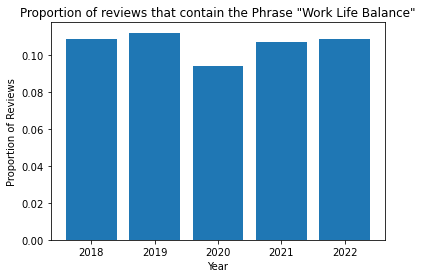

In [58]:
plt.bar(x=proportion.year, height=proportion.percent_wlb);
plt.title('Proportion of reviews that contain the Phrase "Work Life Balance"');
plt.xlabel('Year')
plt.ylabel('Proportion of Reviews');

Work life balance was important for both pros and cons. Thus, we concluded that this was an important part for employees. After plotting the results, it is interesting to see that this was not something that COVID sparked. Having a good work life balance was being mentioned in reviews before COVID.

We have disscussed how WLB appears as a major component in pros and cons. Based on what is entered into each section, we do not think that it has the same effect when mentioned in pros as it does cons.

In [59]:
# rating from pros and cons WLB
wlb_pros = data[data.pros_remove_stop.str.lower().str.contains('work life balance')]
wlb_cons = data[data.cons_remove_stop.str.lower().str.contains('work life balance')]

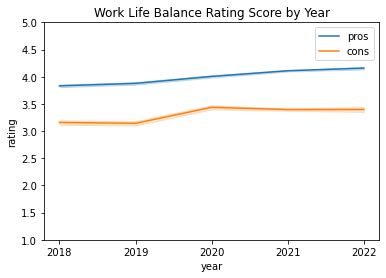

In [60]:
wlb_pros_plot = sns.lineplot(x=wlb_pros.year.astype('str'), y=wlb_pros.rating, label='pros')
sns.lineplot(x=wlb_cons.year.astype('str'), y=wlb_cons.rating, label='cons')
wlb_pros_plot.set_ylim(1, 5);
wlb_pros_plot.set(title='Work Life Balance Rating Score by Year');
wlb_pros_plot.invert_xaxis()

As expected, the pros reviews with WLB tend to have a higher rating than the cons reviews.

Having found the differences in ratings for WLB, let's see the distribution of ratins for reviews that contain WLB vs reviews that don't. I will create a boxplot for this.

In [61]:
# create a 1/0 column to identify WLB (1) or not (0)
# data.free_text_response.str.lower().str.contains('work life balance')
# data.free_text_response.apply(lambda row: if row.str.lower().str.contains('work life balance'), axis=1)
data.loc[data.free_text_response.str.lower().str.contains('work life balance'), 'wlb'] = 1
data['wlb'].fillna(0, inplace=True)
data.head()

,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,characters,pros_words,cons_words,advice_words,free_text_words,avg_length,wlb
0,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexiblitiy is great amongest staff,the work load is overwhelming at times,NaN,2022-03-15,Customer Relations,NaN,NaN,NaN,1.0,flexiblitiy is great amongest staff the work l...,2022,3.0,"[('flexiblitiy', 'n'), ('great', 'a'), ('among...","[('work', 'n'), ('load', 'n'), ('overwhelming'...","[('nan', 'n')]","[('flexiblitiy', 'n'), ('great', 'a'), ('among...",flexiblitiy great amongest staff,work load overwhelming times,NaN,flexiblitiy great amongest staff work load ove...,flexiblitiy great amongest staff,work load overwhelm time,nan,flexiblitiy great amongest staff work load...,0.8,Positive,0.000000,Neutral,0.000000,Neutral,0.800000,Positive,0.6249,-0.1779,0.0000,0.5267,Positive,Neutral,Neutral,Positive,78,5,7,1,13,5.076923,0.0
1,AMERICAN AIRLINES GROUP INC,3.0,4.0,3.0,5.0,3.0,3.0,3.0,yes,no,neutral,Flexible schedules great flight benefits great...,Constantly understaffed in all areas Poor mana...,Hire more people so we aren t constantly delay...,2022-03-15,American Airlines Flight Attendant,New York,NY,5.0,1.0,Flexible schedules great flight benefits great...,2022,3.0,"[('Flexible', 'a'), ('schedules', 'n'), ('grea...","[('Constantly', 'r'), ('understaffed', 'v'), (...","[('Hire', 'n'), ('people', 'n'), ('constantly'...","[('Flexible', 'a'), ('schedules', 'n'), ('grea...",Flexible schedules great flight benefits great...,Constantly understaffed areas Poor management ...,Hire people constantly delayed cancelled,Flexible schedules great flight benefits great...,Flexible schedule great flight benefit great...,Constantly understaffed area Poor management...,Hire people constantly delay cancel,Flexible schedule great flight benefit great...,0.8,Positive,-0.266667,Negative,0.000000,Neutral,0.133333,Positive,0.9201,-0.8176,-0.5106,0.3182,Positive,Negative,Negative,Neutral,214,9,14,12,35,5.625000,0.0
2,AMERICAN AIRLINES GROUP INC,5.0,5.0,5.0,5.0,5.0,5.0,5.0,yes,yes,yes,Love my job Love the freedom not being microma...,Reserve reserve reserve not being able to hold...,NaN,2022-03-15,Flight Attendant,NaN,NaN,NaN,1.0,Love my job Love the freedom not being microma...,2022,3.0,"[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...","[('Reserve', 'n'), ('reserve', 'v'), ('reserve...","[('nan', 'n')]","[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...",Love job Love freedom micromanage,Reserve reserve reserve able hold fll,NaN,Love job Love freedom micromanage Reserve rese...,Love job Love freedom micromanage,Reserve reserve reserve able hold fll,nan,Love job Love freedom micromanage Reserve ...,0.5,Positive,0.500000,Positive,0.000000,Neutral,0.500000,Positive,0.9274,0.0000,0.0000,0.9274,Positive,Neutral,Neutral,Positive,105,9,9,1,19,4.578947,0.0
3,AMERICAN AIRLINES GROUP INC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quit after one month with the company,Working conditions customer service Terrance,Stop being a company full of uneducated low li...,2022-03-15,Pilot,NaN,NaN,NaN,0.0,Quit after one month with the company Working...,2022,3.0,"[('Quit', 'n'), ('one', None), ('month', 

In [62]:
print(data[data.wlb == 1].rating.mean())
print(data[data.wlb == 0].rating.mean())

3.7511360719839364
3.6626583565987176


In [63]:
print(len(data[data.wlb == 0].rating))
print(len(data[data.wlb == 1].rating))

570232
66237


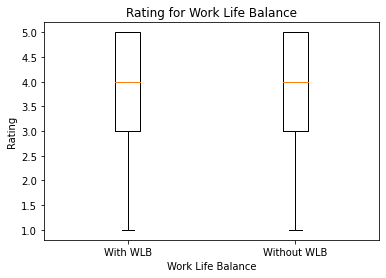

In [64]:
test = [data[data.wlb == 0].rating, data[data.wlb == 1].rating]
fig, ax = plt.subplots()
plt.boxplot(test);
ax.set_xticklabels(['With WLB', 'Without WLB'])
plt.xlabel('Work Life Balance')
plt.ylabel('Rating')
plt.title('Rating for Work Life Balance');

## Work from Home

In [65]:
# work from home dictionary
wfh_dict = ['remote',
           'work from home',
            'work at home',
            'work-from-home',
            'work-at-home'
           'wfh',
           'virtual',
           'home based',
            'home-based',
           'home',
           'telecommute',
           'telework',
           'working from home',
           'home life',
           'home office',
           'work home',
           'COVID']

pattern = '|'.join(wfh_dict)

In [66]:
wfh_df = data[data.free_text_remove_stop.str.lower().str.contains(pattern)]
print(wfh_df.shape)
wfh_df.head()

(29747, 58)


,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,characters,pros_words,cons_words,advice_words,free_text_words,avg_length,wlb
63,AMERICAN AIRLINES GROUP INC,5.0,5.0,5.0,5.0,5.0,4.0,5.0,yes,yes,yes,I help people get to where they need to be thr...,Sometimes when I work odd hours I awaken my hu...,Make the vetting process with Hire Right quick...,2022-03-01,At Home Reservations,NaN,NaN,1.0,1.0,I help people get to where they need to be thr...,2022,3.0,"[('help', 'v'), ('people', 'n'), ('get', 'v'),...","[('Sometimes', 'r'), ('work', 'v'), ('odd', 'a...","[('Make', 'v'), ('vetting', 'n'), ('process', ...","[('help', 'v'), ('people', 'n'), ('get', 'v'),...",help people get need best Airline comfort home...,Sometimes work odd hours awaken husband sweet,Make vetting process Hire Right quicker effici...,help people get need best Airline comfort home...,help people get need best Airline comfort ho...,Sometimes work odd hour awaken husband sweet,Make vetting process Hire Right quicker effi...,help people get need best Airline comfort ho...,1.00,Positive,0.091667,Positive,0.492857,Positive,0.528175,Positive,0.9274,0.1779,0.6908,0.9638,Positive,Neutral,Positive,Positive,310,30,17,17,64,4.049180,0.0
64,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flexibility of your work schedule,long days and uncertainty of getting home on time,NaN,2022-03-01,Flight Attendant,Charlotte,NC,NaN,1.0,Flexibility of your work schedule long days an...,2022,3.0,"[('Flexibility', 'n'), ('work', 'n'), ('schedu...","[('long', 'a'), ('days', 'n'), ('uncertainty',...","[('nan', 'n')]","[('Flexibility', 'n'), ('work', 'n'), ('schedu...",Flexibility work schedule,long days uncertainty getting home time,NaN,Flexibility work schedule long days uncertaint...,Flexibility work schedule,long day uncertainty get home time,nan,Flexibility work schedule long day uncerta...,0.00,Neutral,-0.050000,Negative,0.000000,Neutral,-0.050000,Negative,0.3400,-0.3400,0.0000,0.0000,Neutral,Neutral,Neutral,Neutral,87,5,9,1,15,4.866667,0.0
71,AMERICAN AIRLINES GROUP INC,4.0,3.0,3.0,4.0,4.0,4.0,3.0,yes,yes,yes,Great people travel benefits fun environment,Corporate culture lack of virtual opportunities,NaN,2022-02-28,Account Manager,NaN,NaN,NaN,0.0,Great people travel benefits fun environment C...,2022,2.0,"[('Great', 'a'), ('people', 'n'), ('travel', '...","[('Corporate', 'a'), ('culture', 'n'), ('lack'...","[('nan', 'n')]","[('Great', 'a'), ('people', 'n'), ('travel', '...",Great people travel benefits fun environment,Corporate culture lack virtual opportunities,NaN,Great people travel benefits fun environment C...,Great people travel benefit fun environment,Corporate culture lack virtual opportunity,nan,Great people travel benefit fun environment ...,0.55,Positive,0.000000,Neutral,0.000000,Neutral,0.366667,Positive,0.8860,0.1280,0.0000,0.8979,Positive,Neutral,Neutral,Positive,96,6,6,1,13,6.461538,0.0
87,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flight benefits for all immediate family members,No work from home jobs,NaN,2022-02-25,Analyst,Tempe,AZ,NaN,1.0,Flight benefits for all immediate family membe...,2022,2.0,"[('Flight', 'n'), ('benefits', 'n'), ('immedia...",

In [67]:
count_wfh = pd.DataFrame(wfh_df.groupby('year').count()['free_text_remove_stop']).reset_index()
count_wfh['year'] = count_wfh['year'].astype('int')
count_wfh = count_wfh.groupby('year').sum().reset_index()

count_all = pd.DataFrame(data.groupby('year').count()['free_text_remove_stop']).reset_index()
count_all['year'] = count_all['year'].astype('int')
count_all = count_all.groupby('year').sum().reset_index()

In [68]:
proportion_wfh = count_wfh.merge(count_all, how='inner', on='year').rename(columns={'free_text_remove_stop_x': 'with_wfh', 'free_text_remove_stop_y': 'without_wfh'})
proportion_wfh['percent_wfh'] = proportion_wfh.with_wfh / proportion_wfh.without_wfh
proportion_wfh

,year,with_wfh,without_wfh,percent_wfh
0,2018,4943,91003,0.054317
1,2019,4924,89478,0.055030
2,2020,4846,121482,0.039891
3,2021,11382,261494,0.043527
4,2022,3652,73012,0.050019


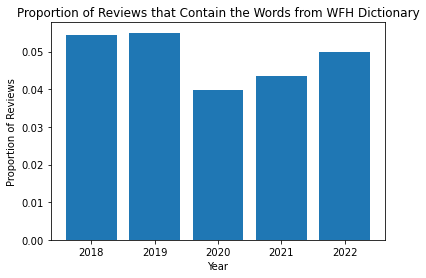

In [69]:
plt.bar(x=proportion_wfh.year, height=proportion_wfh.percent_wfh);
plt.title('Proportion of Reviews that Contain the Words from WFH Dictionary');
plt.xlabel('Year')
plt.ylabel('Proportion of Reviews');

In [70]:
# rating from pros and cons WFH
wfh_pros = wfh_df[wfh_df.pros_remove_stop.str.lower().str.contains(pattern)]
wfh_cons = wfh_df[wfh_df.cons_remove_stop.str.lower().str.contains(pattern)]

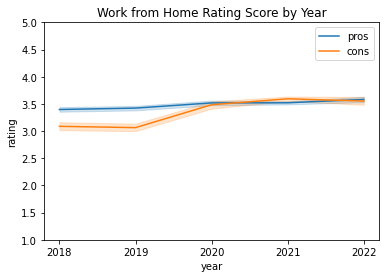

In [71]:
wfh_pros_plot = sns.lineplot(x=wfh_pros.year.astype('str'), y=wfh_pros.rating, label='pros')
sns.lineplot(x=wfh_cons.year.astype('str'), y=wfh_cons.rating, label='cons')
wfh_pros_plot.set_ylim(1, 5);
wfh_pros_plot.set(title='Work from Home Rating Score by Year');
wfh_pros_plot.invert_xaxis()

In [72]:
# create a 1/0 column to identify WLB (1) or not (0)
# data.free_text_response.str.lower().str.contains('work life balance')
# data.free_text_response.apply(lambda row: if row.str.lower().str.contains('work life balance'), axis=1)
data.loc[data.free_text_response.str.lower().str.contains(pattern), 'wfh'] = 1
data['wfh'].fillna(0, inplace=True)
data.head()

,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,year,month,pros_pos_tagged,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,pros_remove_stop,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Polarity,pros_Analysis,cons_Polarity,cons_Analysis,advice_Polarity,advice_Analysis,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,characters,pros_words,cons_words,advice_words,free_text_words,avg_length,wlb,wfh
0,AMERICAN AIRLINES GROUP INC,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexiblitiy is great amongest staff,the work load is overwhelming at times,NaN,2022-03-15,Customer Relations,NaN,NaN,NaN,1.0,flexiblitiy is great amongest staff the work l...,2022,3.0,"[('flexiblitiy', 'n'), ('great', 'a'), ('among...","[('work', 'n'), ('load', 'n'), ('overwhelming'...","[('nan', 'n')]","[('flexiblitiy', 'n'), ('great', 'a'), ('among...",flexiblitiy great amongest staff,work load overwhelming times,NaN,flexiblitiy great amongest staff work load ove...,flexiblitiy great amongest staff,work load overwhelm time,nan,flexiblitiy great amongest staff work load...,0.8,Positive,0.000000,Neutral,0.000000,Neutral,0.800000,Positive,0.6249,-0.1779,0.0000,0.5267,Positive,Neutral,Neutral,Positive,78,5,7,1,13,5.076923,0.0,0.0
1,AMERICAN AIRLINES GROUP INC,3.0,4.0,3.0,5.0,3.0,3.0,3.0,yes,no,neutral,Flexible schedules great flight benefits great...,Constantly understaffed in all areas Poor mana...,Hire more people so we aren t constantly delay...,2022-03-15,American Airlines Flight Attendant,New York,NY,5.0,1.0,Flexible schedules great flight benefits great...,2022,3.0,"[('Flexible', 'a'), ('schedules', 'n'), ('grea...","[('Constantly', 'r'), ('understaffed', 'v'), (...","[('Hire', 'n'), ('people', 'n'), ('constantly'...","[('Flexible', 'a'), ('schedules', 'n'), ('grea...",Flexible schedules great flight benefits great...,Constantly understaffed areas Poor management ...,Hire people constantly delayed cancelled,Flexible schedules great flight benefits great...,Flexible schedule great flight benefit great...,Constantly understaffed area Poor management...,Hire people constantly delay cancel,Flexible schedule great flight benefit great...,0.8,Positive,-0.266667,Negative,0.000000,Neutral,0.133333,Positive,0.9201,-0.8176,-0.5106,0.3182,Positive,Negative,Negative,Neutral,214,9,14,12,35,5.625000,0.0,0.0
2,AMERICAN AIRLINES GROUP INC,5.0,5.0,5.0,5.0,5.0,5.0,5.0,yes,yes,yes,Love my job Love the freedom not being microma...,Reserve reserve reserve not being able to hold...,NaN,2022-03-15,Flight Attendant,NaN,NaN,NaN,1.0,Love my job Love the freedom not being microma...,2022,3.0,"[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...","[('Reserve', 'n'), ('reserve', 'v'), ('reserve...","[('nan', 'n')]","[('Love', 'v'), ('job', 'n'), ('Love', 'n'), (...",Love job Love freedom micromanage,Reserve reserve reserve able hold fll,NaN,Love job Love freedom micromanage Reserve rese...,Love job Love freedom micromanage,Reserve reserve reserve able hold fll,nan,Love job Love freedom micromanage Reserve ...,0.5,Positive,0.500000,Positive,0.000000,Neutral,0.500000,Positive,0.9274,0.0000,0.0000,0.9274,Positive,Neutral,Neutral,Positive,105,9,9,1,19,4.578947,0.0,0.0
3,AMERICAN AIRLINES GROUP INC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quit after one month with the company,Working conditions customer service Terrance,Stop being a company full of uneducated low li...,2022-03-15,Pilot,NaN,NaN,NaN,0.0,Quit after one month with the company Working...,2022,3.0,"[('Quit', 'n'), ('one', N

In [50]:
print(len(data[data.wfh == 0].rating))
print(len(data[data.wfh == 1].rating))

164867
8548


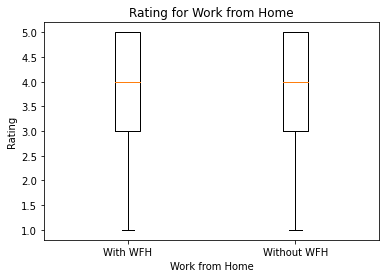

In [73]:
test = [data[data.wfh == 0].rating, data[data.wfh == 1].rating]
fig, ax = plt.subplots()
plt.boxplot(test);
ax.set_xticklabels(['With WFH', 'Without WFH'])
plt.xlabel('Work from Home')
plt.ylabel('Rating')
plt.title('Rating for Work from Home');

-----

# Percent Change

An overall analaysis of the market employer rating is great; however, I fear that with an abundance of reviews, then the average rating will be neutral. Therefore, I want to do a dive into a few (probably 5) companies to see what the rating trends are for a company. My first thought was to take the companies with the most reviews; however, it would be more interesting to analyze the company reviews who had the largest percent change in one year. Thus, we can look at the companies that had the highest percent change year-over-year. This way we have a better path to choose companies to look further into without just anlayzing the companies with the most reviews written. It will be better for storytelling. "I saw these companies had the highest percent change, so I looked further into why this happened."

In [120]:
count_reviews = pd.DataFrame(data.groupby(['year','company']).count()['rating']).reset_index().rename(columns={'rating': 'num_reviews'})
count_reviews.head()

,year,company,num_reviews
0,2018,AFLAC INC,138
1,2018,ALCOA INC,34
2,2018,AMERICAN ELECTRIC POWER CO INC,32
3,2018,AMERICAN EXPRESS CO,806
4,2018,AMERICAN INTERNATIONAL GROUP INC,495


In [121]:
percent_change = data.groupby(['year','company']).mean().reset_index()[['year','company','rating','free_text_Polarity']].sort_values(by='company')
percent_change.head()

,year,company,rating,free_text_Polarity
177,2020,A G L RESOURCES INC,4.750000,0.204494
87,2019,A G L RESOURCES INC,3.833333,0.411947
476,2022,ABBOTT LABORATORIES,3.860544,0.294904
449,2018,ABBOTT LABORATORIES,3.442857,0.256449
469,2021,ABBOTT LABORATORIES,3.860769,0.305163


In [123]:
percent_change = count_reviews.merge(percent_change, on='company')
percent_change.head()

,year_x,company,num_reviews,year_y,rating,free_text_Polarity
0,2018,AFLAC INC,138,2019,3.585106,0.169848
1,2018,AFLAC INC,138,2020,3.739583,0.259148
2,2018,AFLAC INC,138,2021,3.701657,0.277703
3,2018,AFLAC INC,138,2018,3.318841,0.169918
4,2018,AFLAC INC,138,2022,3.710526,0.164227


In [124]:
# percent change = (new-old)/old
percent_change['rating_change'] = np.nan
percent_change['sentiment_change'] = np.nan
for i in range(percent_change.shape[0]-1):
    if percent_change.company[i] == percent_change.company[i+1]:
        percent_change['rating_change'][i+1] = round((percent_change.rating[i+1]  - percent_change.rating[i]) / percent_change.rating[i],4)
        percent_change['sentiment_change'][i+1] = round((percent_change.free_text_Polarity[i+1]  - percent_change.free_text_Polarity[i]) / percent_change.free_text_Polarity[i],4)

In [128]:
# calculate percent change over years
# percent_change = percent_change#.sort_values(by='sentiment_change', ascending=False).reset_index().drop(columns='index')
percent_change = percent_change.groupby(['company']).max().reset_index().sort_values(by='sentiment_change', ascending=False)
percent_change[percent_change.num_reviews > 274]

,company,year_x,num_reviews,year_y,rating,free_text_Polarity,rating_change,sentiment_change
37,BURLINGTON NORTHERN SANTA FE CP,2022.0,397,2022.0,3.481132,0.287189,0.6070,0.5099
2,ADVANCED MICRO DEVICES INC,2022.0,416,2022.0,4.177885,0.346278,0.1455,0.3885
76,DU PONT E I DE NEMOURS and CO,2022.0,349,2022.0,3.873926,0.310905,0.0829,0.3666
39,C I G N A CORP,2022.0,994,2022.0,3.792308,0.298552,0.0935,0.3277
13,AMGEN INC,2022.0,565,2022.0,4.056911,0.314561,0.1070,0.3169
54,COLGATE PALMOLIVE CO,2022.0,314,2022.0,4.269231,0.349262,0.0988,0.2898
47,CHUBB CORP,2022.0,510,2022.0,3.678161,0.274137,0.1141,0.2733
85,EQUIFAX INC,2022.0,493,2022.0,3.750000,0.264615,0.3125,0.2625
43,CARDINAL HEALTH INC,2022.0,666,2022.0,3.812030,0.285895,0.1760,0.2614
89,HONEYWELL INTERNATIONAL INC,NaN,2853,NaN,3.893321,0.278185,0.1452,0.2193


274.0


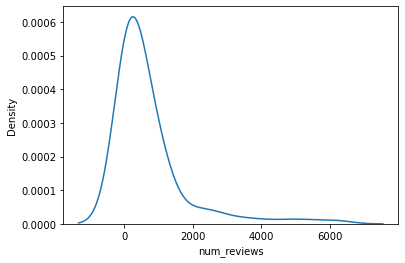

In [127]:
print(percent_change.num_reviews.median())
sns.kdeplot(percent_change['num_reviews']);

In [130]:
burlington = data[data.company=='BURLINGTON NORTHERN SANTA FE CP']

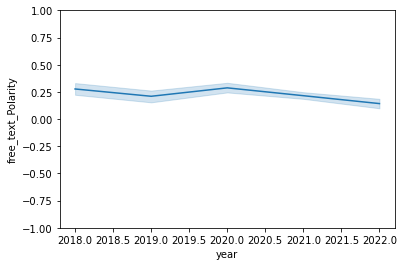

In [133]:
# percent change graph over the years
percent_graph = sns.lineplot(data=burlington, x='year', y='free_text_Polarity');
percent_graph.set_ylim(-1,1);

In [161]:
# find max percent change for a company
max_rating_change = percent_change.groupby(['company']).max().reset_index()[['company','rating_change']]
max_rating_change = max_rating_change.sort_values(by='rating_change', ascending=False).reset_index().drop(columns='index')
max_rating_change

,company,rating_change
0,Walmart,0.1201


In [166]:
largest_change = list(max_rating_change.company[:5])

largest_change

['Walmart']

--------------

# Group by Company

Group by the top 5 companies who had the largest change in sentiment in a year.

In [171]:
# split the data into quarters and do a box plot or bar graph to show the ratings and sentiment per quarter
companies_largest_change = data[data.company.isin(largest_change)]
companies_largest_change.head()

,company,rating,sub_work_life_balance,sub_culture_values,sub_diversity_inclusion,sub_career_opportunities,sub_compensation_benefits,sub_senior_management,recommend,ceo_approval,outlook,pros,cons,advice_management,date,title,city,state,years,current_employee,free_text_response,pros_pos_tagged,pros_remove_stop,cons_pos_tagged,advice_management_pos_tagged,free_text_pos_tagged,cons_remove_stop,advice_management_remove_stop,free_text_remove_stop,pros_Lemma,cons_Lemma,advice_management_Lemma,free_text_Lemma,pros_Subjectivity,pros_Polarity,pros_Analysis,cons_Subjectivity,cons_Polarity,cons_Analysis,advice_Subjectivity,advice_Polarity,advice_Analysis,free_text_Subjectivity,free_text_Polarity,free_text_Analysis,pros_vader_sentiment,cons_vader_sentiment,advice_management_vader_sentiment,free_text_vader_sentiment,pros_vader_analysis,cons_vader_analysis,advice_management_vader_analysis,free_text_vader_analysis,review_length,year,month
0,Walmart,5.0,1.0,5.0,5.0,5.0,5.0,5.0,yes,neutral,yes,I was valued and really enjoyed working at a s...,The hours could definitely improve,NaN,2022-01-14,Customer Service Associate,Rogers,AR,1.0,0.0,I was valued and really enjoyed working at a s...,"[('valued', 'v'), ('really', 'r'), ('enjoyed',...",I valued really enjoyed working store level,"[('hours', 'n'), ('could', None), ('definitely...","[('nan', 'n')]","[('valued', 'v'), ('really', 'r'), ('enjoyed',...",The hours could definitely improve,NaN,I valued really enjoyed working store levelThe...,value really enjoyed work store level,hour could definitely improve,nan,value really enjoyed work store levelThe hou...,0.700000,0.500000,Positive,0.500000,0.000000,Neutral,0.000000,0.000000,Neutral,0.600000,0.250000,Positive,0.7178,0.6808,0.0000,0.8908,Positive,Positive,Neutral,Positive,90.0,2022,1
1,Walmart,5.0,4.0,5.0,5.0,4.0,4.0,NaN,yes,neutral,neutral,Advancement opportunities great at developing ...,Understaffing issues negatively affects all pa...,At the store level any time you are called in ...,2015-06-02,Assistant Store Manager,Amarillo,TX,1.0,0.0,Advancement opportunities great at developing ...,"[('Advancement', 'a'), ('opportunities', 'n'),...",Advancement opportunities great developing ski...,"[('Understaffing', 'v'), ('issues', 'n'), ('ne...","[('store', 'n'), ('level', 'n'), ('time', 'n')...","[('Advancement', 'a'), ('opportunities', 'n'),...",Understaffing issues negatively affects parts ...,At store level time called ride associate foll...,Advancement opportunities great developing ski...,Advancement opportunity great develop skill ...,Understaffing issue negatively affect part b...,store level time call ride associate follow ...,Advancement opportunity great develop skill ...,0.750000,0.800000,Positive,0.500000,0.200000,Positive,0.535185,0.283333,Positive,0.586508,0.407143,Positive,0.9001,0.8934,0.5994,0.9790,Positive,Positive,Positive,Positive,561.0,2015,6
2,Walmart,4.0,4.0,4.0,4.0,3.0,4.0,5.0,yes,NaN,yes,I really enjoy this job Staff is generally eas...,I can t speak for other Walmarts but I wasn t ...,Enthusiastic leadership is extremely important...,2022-01-05,Stocker,Waynesboro,PA,1.0,1.0,I really enjoy this job Staff is generally eas...,"[('really', 'r'), ('enjoy', 'v'), ('job', 'n')...",I really enjoy job Staff generally easy get al...,"[('speak', 'n'), ('Walmarts', 'n'), ('given', ...","[('Enthusiastic', 'a'), ('leadership', 'n'), (...","[('really', 'r'), ('enjoy', 'v'), ('job', 'n')...",I speak Walmarts I given formal training kind ...,Enthusiastic leadership extremely important su...,I really enjoy job Staff generally easy get al...,really enjoy job Staff generally easy get al...,speak Walmarts give formal training kind cra...,Enthusiastic leadership extremely important ...,really enjoy job Staff generally easy get al...,0.629514,0.321181,Positive,0.669888,0.064566,Positive,0.737500,0.437500,Positive,0.663402,0.203084,Positive,0.9750,-0.5267,0.8742,0.9843,Positive,Negative,Positive,Positive,1626.0,2022,1
3,Walmart,4.0,1.0,1.0,2.0,3.0,4

In [175]:
companies_largest_change.loc[(companies_largest_change.month>=1) & (companies_largest_change.month<4), 'quarter'] = 1
companies_largest_change.loc[(companies_largest_change.month>=4) & (companies_largest_change.month<7), 'quarter'] = 2
walmart.loc[(walmart.month>=7) & (companies_largest_change.month<10), 'quarter'] = 3
companies_largest_change.loc[(companies_largest_change.month>=10) & (companies_largest_change.month<=12), 'quarter'] = 4
df = companies_largest_change.groupby(by=['year', 'quarter'])['rating', 'free_text_Polarity'].mean().reset_index()
df

,year,quarter,rating,free_text_Polarity
0,2008,2.0,3.280000,0.157649
1,2008,4.0,3.386364,0.157508
2,2009,1.0,3.232143,0.142043
3,2009,2.0,3.567568,0.150566
4,2009,4.0,3.218750,0.142910
5,2010,1.0,3.040816,0.144007
6,2010,2.0,3.392857,0.162224
7,2010,4.0,3.478261,0.101974
8,2011,1.0,3.466667,0.133819
9,2011,2.0,3.526316,0.201041


In [209]:
print(walmart[walmart['year']==2019].shape[0])
print(walmart[walmart['year']==2022].shape[0])

133
708


In the incomplete quarters, we still have a decent number of reviews.

In [162]:
print(df['rating'].std())
print(df['rating'].std()*2)
print(df['rating'].mean())
print('[', df['rating'].mean()-df['rating'].std()*2, ',', df['rating'].mean()+df['rating'].std()*2 ,']')

0.23695346087108252
0.47390692174216503
3.3030598778205116
[ 2.8291529560783464 , 3.776966799562677 ]


95% of the observations fall between \[~2.83, ~3.78\]. Thus, I would say that the ratings and Polarity do not really fluctuate that much because each quarter is within one standard deviation of the average except Q4 2019. This is also Walmart, ranked \#1 in our Fortune 100 list. Stable company, so this should be expected.

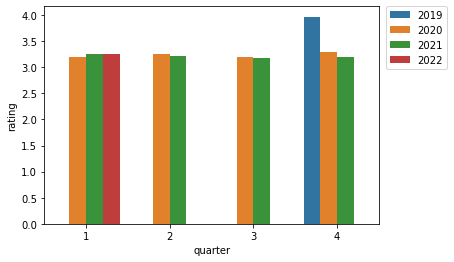

In [210]:
# make this a bar plot
df['quarter'] = np.array(df.index.get_level_values(1))
df['year'] = np.array(df.index.get_level_values(0))
df[np.in1d(df.index.get_level_values(0),[2020,2021])]
# sns.lineplot(data=df, x="quarter", y="rating", hue='year');
# bar plot
sns.barplot(x='quarter', y='rating', data=df, hue='year');
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

------------